# Review Processing ETL
Example notebook for reading and transforming review data.  We read a source, remove SPI, and randomly split into known portions for training and testing data.

In [1]:
# ===============LICENSE_START=======================================================
# Apache-2.0
# ===================================================================================
# Copyright (C) 2019 AT&T Intellectual Property  All rights reserved.
# ===================================================================================
# This software file is distributed by AT&T
# under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ===============LICENSE_END=========================================================

import pandas as pd  # data read
from sklearn import preprocessing  # data ETL
from sklearn.model_selection import train_test_split   # balanced partioning
import os,sys  # file checks
import dill as pickle   # serialize functions and data as compressed binary 
import gzip  # compression 
import yaml   # configuration file
from sklearn.feature_extraction import text  # text processing
from datetime import datetime  # time processing
import ast # help with JSON parsing
from matplotlib import pyplot as plt

## Configuration Options

It's handy to include configuration options in a standard file that can be quickly modified and rerun if you're training something new.  Of course, you can always use command-line configurations as well, but a handy set of defaults in a human-readable file might be a bit easier when you're running things in notebooks.

Here, we're using a simple [YAML](https://camel.readthedocs.io/en/latest/yamlref.html) file for our options which is human-readable, allows comments, and is well supported by other languages.

To modify this program's operation, just open the file `config.yaml` in your editor of choice and rerun this script.

In [2]:
config_path = 'config.yaml'
if not os.path.isfile(config_path):
    print("Sorry, can't find the configuration file {}, aborting.".format(config_path))
    sys.exit(-1)
config = yaml.safe_load(open(config_path))

## Data Exploration
First, let's load our data to see if we need to perform any transform operations.  We will use built-in [JSON reading functions from pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html) that will parse json files into rows and columns to return a standardized [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). 

Of course, you could use whatever library or load function you're used to, but these dataframes have nice interoperability properties with other libraries for learning and manipulation.

In [3]:
if not os.path.isfile(config["path"]["raw"]):
    print("Sorry, can't find the raw input file {}, aborting.".format(config["path"]["raw"]))
    os.exit(-1)

df_raw = pd.read_json(config["path"]["raw"], orient="records", lines=True)
df_raw.sample(5) # handy/pretty preview function within notebooks


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
20222,B00AKWLSO0,"[0, 0]",5,I refuse to buy regular pencils because I am c...,"07 28, 2013",A30Z0GG96D11EO,Wisdom Twin,Great for families!,1374969600
12840,B0045Z4PGQ,"[0, 0]",4,These dividers are for use with half-size fold...,"01 20, 2011",A3GS7OZXUEW48R,Gene Cloner,Durable dividers for half size folders; colors...,1295481600
1541,B00007L6C2,"[0, 0]",4,"It's tough to spice up a review about, well, t...","12 23, 2010",A1J5HIF41ENSMZ,Adam Wood,Excellent tape that tears easily for a straigh...,1293062400
25189,B00JJS7JXK,"[1, 1]",4,5 Star Locker LightManufacturer: Acco BrandsAm...,"06 27, 2014",A3QUDXLOJTKEP9,"C. BLANCHARD ""Desert Reader""",Handy little light (with one exception),1403827200
22650,B00DUJ24M0,"[0, 0]",4,"After comparing the prices, this is a good buy...","09 30, 2013",A2NPF1LZ1S57JV,Sean Paradis,Good for the price,1380499200


## Data Join
This is an okay set of data, but we can actually pull in some other metadata to add more product information.  As with real databases and data feeds, this may occasionally be necessary, but there should always be a "key" or  column that uniquely identifies rows.  Here, it's the column `asin` which is the inventory or product number.

In [4]:
if not os.path.isfile(config["path"]["metadata"]):
    print("Sorry, can't find the metadata input file {}, aborting.".format(config["path"]["metadata"]))
    os.exit(-1)

# a bit of a quirk, the metadata here uses single quotes (ugh!), which is not standard json
# so we must first load and transform that data; see the tip at https://stackoverflow.com/a/48593076
with gzip.open(config["path"]["metadata"], "rt") as f:
    df_meta = pd.DataFrame(ast.literal_eval("["+f.read().replace('\n', ',').replace('\r', '')+"]")).fillna('').astype(str)
    # also go from a string version of array to actual string array
    df_meta["categories"] = df_meta["categories"].apply(lambda x: ast.literal_eval(x.lower())[0])
    
df_meta.sample(5) # handy/pretty preview function within notebooks


,asin,brand,categories,description,imUrl,price,related,salesRank,title
49402,B002UTSO52,Mayer Mill Brass,"[office products, office & school supplies, de...",Mayer Mill Brass is a small family owned compa...,http://ecx.images-amazon.com/images/I/31m8J5%2...,54.01,,,Mayer Mill Brass Modern Home Office Table Deco...
90182,B0072K9OCG,,"[office products, office & school supplies, wr...",Jingle bell collars gently ring while you writ...,http://ecx.images-amazon.com/images/I/31XQuF6v...,12.99,"{'also_viewed': ['B004X9P0U4', 'B005N6JML4', '...",,Jingle Dog Dachshund Pens (Set of 4)
119481,B00CTL04V8,,"[office products, office & school supplies, de...",Profits That Lay Hidden in Your PocketCreate a...,http://ecx.images-amazon.com/images/I/51a1JIxG...,11.95,"{'also_bought': ['B00526MS7A', 'B00D2UO7SQ', '...",,BUSINESS CARD HOLDER - Unique Designer Modern ...
60010,B003TS1IGA,Flash Furniture,"[office products, office furniture & lighting,...",Provide your customers with the ultimate dinin...,http://ecx.images-amazon.com/images/I/41WUF9oo...,49.0,"{'also_viewed': ['B004P89UB8', 'B0062CHKBW', '...",{'Home &amp; Kitchen': 159518},Flash Furniture XU-6FOBXBK-BLKV-GG Hercules Se...
12485,B0009T8DU6,CheckOutStore,"[office products, office & school supplies, en...","100 Mailer 63/8"" x 6""",http://ecx.images-amazon.com/images/I/31oB9GTA...,19.98,"{'also_bought': ['B0000510IA', 'B002ROGCRC', '...",,"100 CD/DVD White Cardboard Mailers, Self Seal ..."


In [5]:
# now we join by ASIN to the raw data
print("Raw samples ({}), metadata records ({})".format(len(df_raw), len(df_meta)))
df_raw = df_raw.set_index("asin").join(df_meta.set_index("asin"), on="asin", how="left")
df_meta = None
print("Combined samples ({})".format(len(df_raw)))
df_raw.sample(5)

Raw samples (25374), metadata records (134838)
Combined samples (25374)


,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,description,imUrl,price,related,salesRank,title
asin,,,,,,,,,,,,,,,,
B003O3F2R6,"[0, 0]",5,I've received a number of binders and notebook...,"07 2, 2014",A1ZPY91VE3IDN1,JO,"Conceptually innovative, structurally sound, a...",1404259200,,"[office products, office & school supplies, bi...",,http://ecx.images-amazon.com/images/I/518LBu6r...,16.15,"{'also_bought': ['B00JIX5KO6', 'B002N6EB7M', '...",,"Five Star Flex Hybrid NoteBinder, 1-Inch Capac..."
B005IIR8H2,"[20, 23]",4,I selected this printer because I do a lot of ...,"10 1, 2011",A11OTLEDSW8ZXD,CGScammell,"Easy set-up, colors are natural",1317427200,Epson,"[office products, office electronics, printers...",,http://ecx.images-amazon.com/images/I/41GjSN6-...,217.49,"{'also_bought': ['B005LPIHLS', 'B005LPIHN6', '...",,Epson WorkForce Pro WP-4540 All-in-One Printer
B004GEC2IY,"[0, 1]",2,The BIC Triumph 730RT Gel Pen (0.7mm) is a nic...,"06 23, 2011",A1ILWPH1GHUXE2,JB,Stylish - but there are better gel pens for mu...,1308787200,,"[office products, office & school supplies, wr...",BIC Triumph 730RT Gel is streamlined and sophi...,http://ecx.images-amazon.com/images/I/31AXHnJc...,,"{'also_viewed': ['B004GEC2HU', 'B008AP8Y8M', '...",,"BIC Triumph 730RT Gel Pen (0.7mm), Black, 12ct..."
B00AQ2BZZQ,"[0, 0]",3,"As other reviewers have pointed out, this is d...","07 1, 2014",A70NFM6KHU24F,Trevor Burnham,Adhesive is too light for box sealing,1404172800,,"[office products, office & school supplies, en...",Scotch&#xAE; Printed Message Box Sealing Tape ...,http://ecx.images-amazon.com/images/I/51uJnbjL...,8.99,"{'also_bought': ['B00AQ2C37U', 'B00AEY6IJY', '...",{'Industrial & Scientific': 33205},Scotch Printed Message CHECK SEAL BEFORE ACCEP...
B00ASHH602,"[0, 0]",5,This little label printer is fun and easy to u...,"05 4, 2013",A33PVCHCQ2BTN0,SuzieB,"Easy to use, and practical!",1367625600,Epson,"[office products, office electronics, other of...",Take Ordinary to Extraordinary. Create persona...,http://ecx.images-amazon.com/images/I/31hWEtn2...,56.19,"{'also_bought': ['B005S0KG7O', 'B005S0KE7G', '...",,Epson LabelWorks Iron-On Kit (C51CB69130)


In [6]:
print(df_raw.iloc[0]) # take a closer look at just one row/sample

helpful                                                      [0, 0]
overall                                                           5
reviewText        This is a really good, high-quality product.  ...
reviewTime                                              10 29, 2010
reviewerID                                           A1P2XYD265YE21
reviewerName                                    Andrea "Readaholic"
summary                                                 Really Good
unixReviewTime                                           1288310400
brand                                                         Avery
categories        [office products, office & school supplies, pa...
description       Perfect for invitations, thank you notes, movi...
imUrl             http://ecx.images-amazon.com/images/I/51q11PWY...
price                                                          8.42
related           {'also_bought': ['B0000AQNVK', 'B00007E7CW', '...
salesRank                                       

## Partitions
To avoid data bias and contamination, let's break apart the data into `training` and `testing` (aka `evaluation`) sets. These partitions help us to avoid the problems of over-fitting and under-fitting while training for our problem.  Additionally, by doing the segmentation this early in model building, we'll be able to keep consistent samples for comparing different models that are evaluated.  In the special function `train_test_split` we specify the column `overall` so that we get a set of balanced classes in our training and testing data.

In some works, a third split often called `validation` can be used for parameter tuning after training but before testing on unseen data.

Here are a few quick ETL (extract, transform, load) steps we're performing...

1. We also see that a few fields, `reviewerID` and `reviewerName` are likely SPI (sensitive personal information) that we don't need in any of our analysis, so we will summarily `delete` it. 

2. There is a redundant field `reviewTime` that is a repeated text form of `unixReviewTime` so we can delete it, too.

3. We don't want our model to learn anything specific to unique products, so we will also drop the column `brand`, `price`, `salesRank`, `imUrl`, `related`, `title`, and `asin`.

### Excise your labels
Don't forget to exclude class labels from the training data or else you'll get 100% accuracy and probably a slap on the wrist from your model development friends!

In [7]:
if "reviewerID" in df_raw.columns:
    df_raw.drop(["reviewerID", "reviewerName", "reviewTime", "brand", "price", "salesRank", "imUrl", "related", "title"], inplace=True, axis=1)
df_raw.reset_index(drop=True, inplace=True)
    
# now compare to the prior data above
df = {}
df["X_train"], df["X_test"] = train_test_split(df_raw, stratify=df_raw["overall"],
                                        test_size=config["partition"]["test"], 
                                        random_state=0)

# finally, let's grab our label column ("overall") that we're trying to predict
df["y_train"] = df["X_train"]["overall"]
del df["X_train"]["overall"]
df["y_test"] = df["X_test"]["overall"]
del df["X_test"]["overall"]

models = {}  # this will allow us to persist models
print(df["X_train"].iloc[0]) # take a closer look at just one row/sample (after dropping)
print("Dimensionality before processing {}".format(df["X_train"].shape))


helpful                                                      [1, 1]
reviewText        Oh my Avery, how I LOVE you!!  I am a total ne...
summary           Another wonderful Avery product that feeds my ...
unixReviewTime                                           1287619200
categories        [office products, office & school supplies, la...
description                                                        
Name: 665, dtype: object
Dimensionality before processing (20299, 6)


## Transforms
From the above explorations, we can see that we'll need to transform the data into a numerical representation before we can continue. 


### Textual Transforms
For text data, there are a million ways you can go from text to numerical featues, with ealy, tried and true techniques like [frequency vectors](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) and [hashing vectors](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer) where all words are counted and then assigned to a fixed feature dimension to more complex methods like [word embedding](https://en.wikipedia.org/wiki/Word_embedding).  

There are also tons of pre-processing steps that can be added like [stemming](https://pythonspot.com/nltk-stemming/) and [stop word removal](https://pythonspot.com/nltk-stop-words/), but those additional steps are left as exercises for the reader.

In this sample ETL code, we'll extract [normalized TFIDF counts](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) with English stop words and a maximum number of textual features, which is just one step above the simpler counts alone.  A richer demonstration with this library can be [found here](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py).


In [8]:
def preproc_text(models, df_test, df_train=None, verbose=False):
    # train text models for both big text columns
    for c in ["reviewText","summary","description"]:
        if verbose:
            print("Preprocessing text column '{}'...".format(c))
        encN = "enc_text_{}".format(c)
        encC = "enc_cols_{}".format(c)
        # create and train vectorizer
        if df_train is not None:
            models[encN] = text.TfidfVectorizer(
                stop_words="english", max_features=config["encoding"]["max_text_terms"])
            models[encN].fit(df_train[c])
            
        # encode new features to dataframe
        models[encC] = ["{}_{}".format(c[0:2], n) for n in models[encN].get_feature_names()]
        tmp_encode = pd.DataFrame(models[encN].transform(df_test[c]).toarray(), 
                                  index=df_test.index, columns=models[encC])    
        df_test = pd.concat([df_test, tmp_encode], axis=1, sort=False)
        # delete prior columns
        df_test.drop(c, axis=1, inplace=True)
        if verbose:
            print("... dimensionality after processing {}".format(df_test.shape))

    # now, normalize the list of helpfulness of the review scores 
    #   (e.g. [1,2] which is "Yes/No") into a l1 unit vector of counts [0.2, 0.8] 
    if verbose:
        print("Preprocessing vectorized 'helpful' ...")
    if df_train is not None:
        models["fn_preproc_normalize"] = preprocessing.normalize
    tmp_encode = models["fn_preproc_normalize"](list(df_test["helpful"]), norm='l1')
    tmp_encode = pd.DataFrame(tmp_encode, columns=["help_0", "help_1"], index=df_test.index)
    df_test = pd.concat([df_test, tmp_encode], axis=1, sort=False)
    # delete prior columns
    df_test.drop("helpful", axis=1, inplace=True)
    return models, df_test
    
models["fn_preproc_text"] = preproc_text
models, df["X_train"] = models["fn_preproc_text"](models, df["X_train"], df["X_train"], True)

Preprocessing text column 'reviewText'...
... dimensionality after processing (20299, 305)
Preprocessing text column 'summary'...
... dimensionality after processing (20299, 604)
Preprocessing text column 'description'...
... dimensionality after processing (20299, 903)
Preprocessing vectorized 'helpful' ...


### Categorical Transforms
For categorical data, there are two popular methods to encode non-numerical data: [one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and simply [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder).  

Label encoding is the simpler of the two and it enumerates all of your known values into numerical values.  It offers smaller final dimensionality and if the values are releated, it might make sense to keep them ordinally related.  For example, mapping the quality grades "poor, acceptable, good" into a single ordinal.
```
    transform([['apple']; ['orange']; ['bannana']]) --> [[0]; [1]; [2]]
```

One-hot encoding also enumerates all known values into binary vectors.  Some classifiers learn depenencies between numerical values, so assigning several unrelated numbers could actually hurt your case.
```
    transform([['apple']; ['orange']; ['bannana']]) --> [[1 0 0]; [0 1 0]; [0 0 1]]
```

This data actually has the column `categories` which can contain multiple categories (e.g. `["chair","office"]`, so we'll run the transform there but use a [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) which works like one-hot encoding, but allows multiple items to be simultaneously active.


In [9]:
def preproc_category(models, df_test, df_train=None, verbose=False):
    # specify the columns of interest
    if verbose:
        print("Preprocessing one-hot category columns...")
    if df_train is not None:
        models["col_hot"] = "categories"
        # train and transform columns
        models["enc_hot"] = preprocessing.MultiLabelBinarizer()
        models["enc_hot"].fit(df_train[models["col_hot"]])
        # compute new column names after encoding
        models["col_hot_enc"] = ["cat_{}".format(x) for x in models["enc_hot"].classes_]
    # combine into new larger matrix
    tmp_encode = pd.DataFrame(models["enc_hot"].transform(df_test[models["col_hot"]]), 
                              index=df_test.index, columns=models["col_hot_enc"])
    df_test = pd.concat([df_test, tmp_encode], axis=1, sort=False)
    # delete prior columns for raw data
    df_test.drop(models["col_hot"], axis=1, inplace=True)
    if verbose:
        print("... dimensionality after processing {}".format(df_test.shape))

    # another way to do category encoding with just two values (e.g. On/Off)
    # # specify the columns of interest
    # models["col_binary"] = ["Partner", "Dependents", "PhoneService", "InternetService", \
    #                   "PaperlessBilling", "Churn"]
    # # train and transform columns
    # models["enc_binary"] = preprocessing.OrdinalEncoder()  # this is a multi-feature version of LabelEncoder
    # models["enc_binary"].fit(df["X_train"][models["col_binary"]])
    # # overwrite previous data with transformation
    # df["X_train"][models["col_binary"]] = models["enc_binary"].transform(df["X_train"][models["col_binary"]])
    # df["X_test_enc"][models["col_binary"]] = models["enc_binary"].transform(X_tdf["X_test_enc"]est_enc[models["col_binary"]])
    return models, df_test

models["fn_preproc_category"] = preproc_category
models, df["X_train"] = models["fn_preproc_category"](models, df["X_train"], df["X_train"], True)

Preprocessing one-hot category columns...
... dimensionality after processing (20299, 1112)


### Time Transforms
One more tweak is to pull out 'day of week' from our timestamp. Generally, you'd want to disregard all time information for a fair learning but some [studies demonstrate positive skews over time](https://hbr.org/2018/10/research-why-ratings-on-everything-from-wine-to-amazon-products-improve-over-time).  

Here, we're keeping both the raw timestamp (to account for above) and a day of week as an example of how to process and extract a time segment.


In [10]:
def preproc_time(models, df_test, df_train=None, verbose=False):
    if verbose:
        print("Preprocessing vectorized 'unixReviewTime' ...")
    df_time = pd.to_datetime(df_test["unixReviewTime"], unit='s')
    df_test["t_DOW"] = df_time.dt.dayofweek
    df_test["t_month"] = df_time.dt.month
    df_test["t_year"] = df_time.dt.year
    df_test["t_day"] = df_time.dt.day
    if verbose:
        print("... dimensionality after processing {}".format(df_test.shape))
    del df_test["unixReviewTime"]
    return models, df_test

models["fn_preproc_time"] = preproc_time
models, df["X_train"] = models["fn_preproc_time"](models, df["X_train"], df["X_train"], True)

Preprocessing vectorized 'unixReviewTime' ...
... dimensionality after processing (20299, 1116)


In [11]:
# finally we should able to cast all data to a double format
# however, some values for "TotalCharges" were missing, so set them to zero
print("Final dimensionality after processing {}".format(df["X_train"].shape))

# now compare to the prior data above
df["X_train"].head(10)

Final dimensionality after processing (20299, 1115)


,re_10,re_34,re_3m,re_able,re_actually,re_address,re_adhesive,re_amazon,re_avery,re_away,...,cat_voip,cat_wall calendars,cat_wirebound notebooks,cat_wooden colored pencils,cat_wrist rests,cat_writing & correction supplies,t_DOW,t_month,t_year,t_day
665,0.0,0.0,0.000000,0.04116,0.0,0.0,0.0,0.0,0.256743,0.046824,...,0,0,0,0,0,0,3,10,2010,21
23034,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,2,2014,24
8253,0.0,0.0,0.641406,0.00000,0.0,0.0,0.0,0.0,0.407494,0.000000,...,0,0,0,0,0,0,3,1,2010,21
1963,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,3,5,2011,5
22147,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,6,9,2013,15
14291,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,2,8,2011,17
11506,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,1,12,2010,14
3696,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,1,12,2010,14
7324,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.106228,0.000000,...,0,0,0,0,0,0,3,10,2010,21
16380,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.262049,0.000000,...,0,0,0,0,0,0,3,3,2012,15


## Normalization and Scaling
Let's take advantage of a [outlier-robust scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) to get things into shape and between the ranges of `[0,1]`.

There are other handy tricks to [normalize or scale](https://en.wikipedia.org/wiki/Normalization_(statistics)) your data, but we'll leave that as an exercise for the future. 

After scaling, we quickly visualize the training samples for a few fields and see that most of our features are reaonsable.  In this boxplot, the circles are sample values, green lines are the mean, and blue error bars show the variance of the mean.  Features that have no error bars indicate that they are mostly sparse.

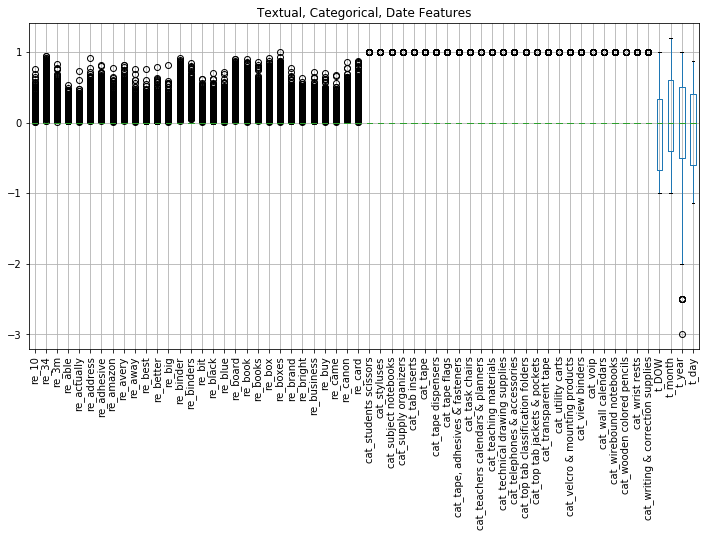

In [12]:
def preproc_scaler(models, df_test, df_train=None, verbose=False):
    if df_train is not None:
        models["scaler"] = preprocessing.RobustScaler()
        models["scaler"].fit(df_train)
        df_train = pd.DataFrame(models["scaler"].transform(df_train), 
                             index=df_train.index, columns=df_train.columns)
        
        # visualize the ranges of all data
        if verbose:
            col_show = df_train.columns[:30].append(df_train.columns[-30:])
            ax = df_train[col_show].boxplot(figsize=(12,6), rot=90)
            ax.set_title("Textual, Categorical, Date Features")
            plt.show()
    # scale the test data
    df_test = pd.DataFrame(models["scaler"].transform(df_test), index=df_test.index, columns=df_test.columns)
    return models, df_test

models["fn_preproc_scaler"] = preproc_scaler
models, df["X_train"] = models["fn_preproc_scaler"](models, df["X_train"], df["X_train"].copy(), True)

def preproc_numeric(models, df_test, df_train=None, verbose=False):
    df_test = df_test.apply(pd.to_numeric, errors='corce').fillna(0).astype(float)
    return models, df_test

models["fn_preproc_numeric"] = preproc_numeric
# we passed a copy because it is mutated in the fuction
models, df["X_train"] = models["fn_preproc_numeric"](models, df["X_train"], df["X_train"].copy(), True)


## Function Pooling
We went through a lot of process here, so let's wrap all of the pre-processing sub-functions into one function.  Specifically, this is what it takes to go from our 'test' data to our 'encoded' test data.

In [13]:
def preproc_etl(models, df_test, steps=["text", "category", "time", "numeric", "scaler"], verbose=False):
    if "text" in steps:
        models, df_test = models["fn_preproc_text"](models, df_test, None, verbose)
    if "category" in steps:
        models, df_test = models["fn_preproc_category"](models, df_test, None, verbose)
    if "time" in steps:
        models, df_test = models["fn_preproc_time"](models, df_test, None, verbose)
    if "numeric" in steps:
        models, df_test = models["fn_preproc_numeric"](models, df_test, None, verbose)
    if "scaler" in steps:
        models, df_test = models["fn_preproc_scaler"](models, df_test, None, verbose)
    return df_test

# save the FUNCTION and a data example for later use!
models["fn_preproc"] = preproc_etl
models["fn_input"] = df["X_test"].sample(1)

# Data Archive
Finally, we'll save all of our processed data (post-ETL) and functions for later use!

In [14]:
# finally, let's save all of this data to disk
df["X_train"].sample(100).to_csv(config["path"]["example"], index=False)

# write out our larger datasets as binary files
with gzip.open(config["path"]["etl"], 'wb') as f:
    pickle.dump(df, f)

# and write out our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_preproc"], 'wb') as f:
    pickle.dump(models, f)

# write out some stats
print("Created encoded training set {}x{} (labels {}) " \
      "and raw test set {}x{} (partition size {}) ".format( \
    len(df["X_train"]), len(df["X_train"].columns), len(df["y_train"]), 
    len(df["X_test"]), len(df["X_test"].columns), config["partition"]["test"]))

Created encoded training set 20299x1115 (labels 20299) and raw test set 5075x6 (partition size 0.2) 


# A Self-Driven Experiment
Now that we have the full pipeline for transforming an incoming sample, let's try evaluating one of your own making.  First we'll show the remaining in put features and second we'll use programatic entry (here in this script) to evaluate it as features.

In [15]:
print(df["X_test"].iloc[0])

helpful                                                      [1, 1]
reviewText        There's nothing more dispiriting than spending...
summary                              These tabs perform as promised
unixReviewTime                                           1293840000
categories        [office products, office & school supplies, la...
description       Post-it(R) Tabs in 1 inch size create necessar...
Name: 6824, dtype: object


In [16]:
# Now you try it at home!
df_user = pd.DataFrame([{"helpful":[0,0], 
    "reviewText":"This was a great product that I never use enough of when I participated in a workshop last week",
    "summary":"Always there when needed", "categories":["office products"],
    "description":"Two magic keyboards with a real tactile feeling",
    "unixReviewTime":datetime.now().timestamp()}])
print(df_user.iloc[0])
print("Now processing user data...")
df_scaled = models["fn_preproc"](models, df_user)
print(df_scaled)

categories                                        [office products]
description         Two magic keyboards with a real tactile feeling
helpful                                                      [0, 0]
reviewText        This was a great product that I never use enou...
summary                                    Always there when needed
unixReviewTime                                          1.55411e+09
Name: 0, dtype: object
Now processing user data...
   re_10  re_34  re_3m  re_able  re_actually  re_address  re_adhesive  \
0    0.0    0.0    0.0      0.0          0.0         0.0          0.0   

   re_amazon  re_avery  re_away  ...  cat_voip  cat_wall calendars  \
0        0.0       0.0      0.0  ...       0.0                 0.0   

   cat_wirebound notebooks  cat_wooden colored pencils  cat_wrist rests  \
0                      0.0                         0.0              0.0   

   cat_writing & correction supplies  t_DOW  t_month  t_year     t_day  
0                            